In [1]:
import os
import glob
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point

In [2]:
# File paths for your CSV files
file_paths = [
    'AEM_WELL_LITHOLOGY_csv_WO4_20230831.csv',
    'AEM_WELL_LITHOLOGY_csv_WO5_20230125.csv',
    'AEM_WELL_LITHOLOGY_csv_WO6_20230103.csv',
    'AEM_WELL_LITHOLOGY_csv_WO7_20230327.csv',
]

In [3]:
# List to hold dataframes
dataframes = []

# Read each CSV file and append to the list
for file_path in file_paths:
    try:
        # Attempt to read with default encoding
        df = pd.read_csv(file_path)
        dataframes.append(df)
    except UnicodeDecodeError:
        try:
            # Try reading with a different encoding if the first attempt fails
            df = pd.read_csv(file_path, encoding='latin1')
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except pd.errors.EmptyDataError:
        print(f"File is empty: {file_path}")
    except pd.errors.ParserError:
        print(f"Error parsing file: {file_path}")

# Concatenate all dataframes
if dataframes:
    merged_df = pd.concat(dataframes, ignore_index=True)
    print(merged_df)
else:
    print("No dataframes to merge.")

C:\Users\betebari\AppData\Local\Temp\ipykernel_9340\2185420019.py:8: DtypeWarning: Columns (2,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\betebari\AppData\Local\Temp\ipykernel_9340\2185420019.py:8: DtypeWarning: Columns (2,15,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\betebari\AppData\Local\Temp\ipykernel_9340\2185420019.py:13: DtypeWarning: Columns (3,4,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='latin1')
C:\Users\betebari\AppData\Local\Temp\ipykernel_9340\2185420019.py:8: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


        LITH_ID  WELL_INFO_ID LOCAL_ID1 LOCAL_ID2  \
0         46615             1       NaN    8841.0   
1         46616             1       NaN    8841.0   
2         46617             1       NaN    8841.0   
3         46618             1       NaN    8841.0   
4         46619             1       NaN    8841.0   
...         ...           ...       ...       ...   
679116   122099         12022       NaN       NaN   
679117   122100         12022       NaN       NaN   
679118   122101         12022       NaN       NaN   
679119   122102         12022       NaN       NaN   
679120   122103         12022       NaN       NaN   

                             LOCAL_ID3  X_CATEALEALBERS_m  Y_CATEALEALBERS_m  \
0                                  NaN        46235.86635       -314240.5205   
1                                  NaN        46235.86635       -314240.5205   
2                                  NaN        46235.86635       -314240.5205   
3                                  NaN     

In [4]:
# Rename the columns
merged_df = merged_df.rename(columns={
    'GROUND_SURFACE_ELEVATION_m': 'GSE_m',
    'LITH_TOP_DEPTH_m': 'INTERVALSTART_m',
    'LITH_BOT_DEPTH_m': 'INTERVALEND_m',
    'WELL_INFO_ID' : 'WCRNUMBER'
})

# Display the resulting dataframe

In [5]:
# Unit Conversion meters to feet

merged_df['GSE_ft'] = merged_df['GSE_m'] * 3.28084
merged_df['INTERVALSTART'] = merged_df['INTERVALSTART_m'] * 3.28084
merged_df['INTERVALEND'] = merged_df['INTERVALEND_m'] * 3.28084

In [6]:
# Drop specified columns
merged_df = merged_df.drop(columns=['GSE_m','INTERVALSTART_m', 'INTERVALEND_m'])

In [7]:
# Drop columns that are no longer needed
merged_df.drop(columns=['LITH_TRANSCRIPTION','LOCAL_ID3', 'LITH_MAJOR1', 'LITH_MAJOR2' ,'LITH_MINOR1'
            ,'RAW_DESCRIPTION', 'DATA_SOURCE' , 'DESCRIPTOR', 'QAQC',
    'LITH_MINOR2','TEXTURE', 'TEXTURE_REFINED' , 'COLOR', 'NOTES'], inplace=True)
                            
# Convert DataFrame to GeoDataFrame
merged_df = gpd.GeoDataFrame(
    merged_df,
    geometry=gpd.points_from_xy(merged_df['X_CATEALEALBERS_m'], merged_df['Y_CATEALEALBERS_m']),
    crs="EPSG:3310"  # Original CRS
)

# WCR's locations 2 shapefile
merged_df.to_file('AEM_supp.shp', driver='ESRI Shapefile')

C:\Users\betebari\AppData\Local\Temp\ipykernel_9340\2642532164.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_df.to_file('AEM_supp.shp', driver='ESRI Shapefile')


<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

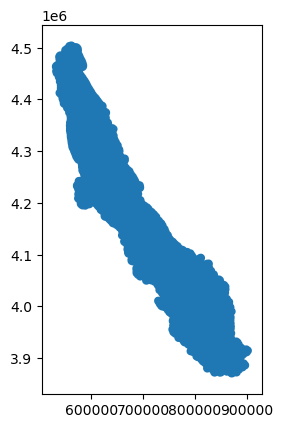

In [8]:
aquifer_boundary = gpd.read_file('central_val_buf_5mil_utm10n.shp')
aquifer_boundary.plot()
aquifer_boundary.crs

In [9]:
# Reproject to EPSG:26910
gdf_Ramboll = merged_df.to_crs("EPSG:26910")

# Extract UTM X and Y coordinates from the geometry column
gdf_Ramboll['UTMX'] = gdf_Ramboll.geometry.x
gdf_Ramboll['UTMY'] = gdf_Ramboll.geometry.y

# Save or use the reprojected GeoDataFrame
print(gdf_Ramboll)

# Optionally save the reprojected GeoDataFrame to a new file
gdf_Ramboll.to_file("reprojected_AEM_supporting.shp")

        LITH_ID  WCRNUMBER LOCAL_ID1 LOCAL_ID2  X_CATEALEALBERS_m  \
0         46615          1       NaN    8841.0        46235.86635   
1         46616          1       NaN    8841.0        46235.86635   
2         46617          1       NaN    8841.0        46235.86635   
3         46618          1       NaN    8841.0        46235.86635   
4         46619          1       NaN    8841.0        46235.86635   
...         ...        ...       ...       ...                ...   
679116   122099      12022       NaN       NaN      -172051.02680   
679117   122100      12022       NaN       NaN      -172051.02680   
679118   122101      12022       NaN       NaN      -172051.02680   
679119   122102      12022       NaN       NaN      -172051.02680   
679120   122103      12022       NaN       NaN      -172051.02680   

        Y_CATEALEALBERS_m USCS_SYMBOL USCS_DESCRIPTION      GSE_ft  \
0            -314240.5205       CH/CL             Clay  927.580030   
1            -314240.5205      

C:\Users\betebari\AppData\Local\Temp\ipykernel_9340\1831986779.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_Ramboll.to_file("reprojected_AEM_supporting.shp")


In [10]:
clipped_points = gpd.clip(gdf_Ramboll, aquifer_boundary)
print(clipped_points.shape)
print(clipped_points.head())

(658686, 14)
       LITH_ID  WCRNUMBER LOCAL_ID1 LOCAL_ID2  X_CATEALEALBERS_m  \
92389   217727      18926       NaN       NaN         104444.274   
92367   217705      18926       NaN       NaN         104444.274   
92398   217736      18926       NaN       NaN         104444.274   
92397   217735      18926       NaN       NaN         104444.274   
92396   217734      18926       NaN       NaN         104444.274   

       Y_CATEALEALBERS_m USCS_SYMBOL USCS_DESCRIPTION      GSE_ft  \
92389       -337114.7239       CH/CL    Gravelly clay  959.850031   
92367       -337114.7239          SC      Clayey Sand  959.850031   
92398       -337114.7239       CH/CL    Gravelly clay  959.850031   
92397       -337114.7239       SW/SP             Sand  959.850031   
92396       -337114.7239        Rock      Sedimentary  959.850031   

       INTERVALSTART  INTERVALEND                        geometry  \
92389     150.000005   210.000007  POINT (878433.650 3878343.493)   
92367     440.000014   48

In [11]:
clipped_points.to_file("clipped_gdf_Ramboll.shp")


C:\Users\betebari\AppData\Local\Temp\ipykernel_9340\3264841021.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_points.to_file("clipped_gdf_Ramboll.shp")


C:\Users\betebari\AppData\Local\Temp\ipykernel_9340\2961905775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clipped_points.drop(columns=['X_CATEALEALBERS_m','Y_CATEALEALBERS_m' ,


Number of unique WCRNUMBER values: 16899


,WCRNUMBER,USCS,DESCRIPTION,GSE_ft,INTERVALSTART,INTERVALEND,geometry,UTMX,UTMY
92389,18926,CH/CL,Gravelly clay,959.850031,150.000005,210.000007,POINT (878433.650 3878343.493),878433.650475,3.878343e+06
92367,18926,SC,Clayey Sand,959.850031,440.000014,480.000015,POINT (878433.650 3878343.493),878433.650475,3.878343e+06
92398,18926,CH/CL,Gravelly clay,959.850031,240.000008,260.000008,POINT (878433.650 3878343.493),878433.650475,3.878343e+06
92397,18926,SW/SP,Sand,959.850031,1130.000036,1190.000038,POINT (878433.650 3878343.493),878433.650475,3.878343e+06
92396,18926,Rock,Sedimentary,959.850031,810.000026,830.000027,POINT (878433.650 3878343.493),878433.650475,3.878343e+06


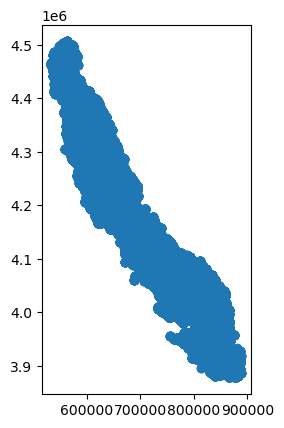

In [12]:
# Drop columns that are no longer needed
clipped_points.drop(columns=['X_CATEALEALBERS_m','Y_CATEALEALBERS_m' ,
                      'LOCAL_ID1', 'LOCAL_ID2' , 'LITH_ID' , 
                       ], inplace=True)

# Rename the columns
clipped_points = clipped_points.rename(columns={
    'WELL_INFO_ID': 'WCRNUMBER',
    'USCS_DESCRIPTION' : 'DESCRIPTION','USCS_SYMBOL': 'USCS'})

# Get the number of unique values in the 'WCRNUMBER' column
unique_wcrnumber_count = clipped_points['WCRNUMBER'].nunique()
print(f"Number of unique WCRNUMBER values: {unique_wcrnumber_count}")
clipped_points.plot()
clipped_points.head()
# Display the resulting dataframe

In [18]:
import re
# Load the provided Excel file
file_path = r'C:\Users\betebari\Documents\C2VSim_Texture\OSWCR\USCS-averageKxy-CoarseFractions.xlsx'
excel_data = pd.read_excel(file_path)

# Strip leading/trailing spaces and convert to lowercase in 'Sediment/Rock Type' for consistency
excel_data['Sediment/Rock Type'] = excel_data['Sediment/Rock Type'].str.strip().str.lower()

# Create a dictionary mapping Soil Classification to Average Hydraulic Conductivity
hydraulic_conductivity_mapping = dict(zip(excel_data['Sediment/Rock Type'], excel_data['Average Hydraulic Conductivity (ft/day)']))

# Create a dictionary mapping Soil Classification to Average Coarse Fraction
coarse_fraction_mapping = dict(zip(excel_data['Sediment/Rock Type'], excel_data['Average Coarse Fraction (%)']))

# Create separate mappings for Specific Yield, Ss, and Kv based on the Excel data columns
specific_yield_mapping = dict(zip(excel_data['Sediment/Rock Type'], excel_data['Avg Specific Yield (%)']))
ss_mapping = dict(zip(excel_data['Sediment/Rock Type'], excel_data['Avg Ss (1/L)']))
kv_mapping = dict(zip(excel_data['Sediment/Rock Type'], excel_data['Avg Kv (ft/day)']))

# Clean the 'USCS' column in the merged DataFrame
clipped_points['USCS'] = clipped_points['USCS'].str.strip().str.replace(r'[\(\)]', '', regex=True).str.lower()

def aggregate_uscs_values(uscs_value, mapping, agg_func='average'):
    # Handle NaN or non-string values
    if pd.isna(uscs_value) or not isinstance(uscs_value, str):
        return None  # You can replace None with a default value if needed

    # Handle 'unknown' case
    if 'unknown' in uscs_value:
        return None  # Replace None with a default value, e.g., 0

    # Corrected regex to handle different separators
    uscs_classes = re.split(r'[,&/]', uscs_value)  # Adjust splitting for multiple separators

    # Extract values based on mapping and apply the aggregation function
    mapped_values = [mapping.get(uscs.strip()) for uscs in uscs_classes if uscs.strip() in mapping]

    # Special case handling for 'gc-gm' and 'sc-sm'
    if uscs_value in ['gc-gm', 'sc-sm']:
        gc_value = mapping.get('gc', None)
        gm_value = mapping.get('gm', None)
        sc_value = mapping.get('sc', None)
        sm_value = mapping.get('sm', None)

        # Example logic: calculate average for 'gc-gm' or 'sc-sm'
        if uscs_value == 'gc-gm':
            mapped_values = [gc_value, gm_value]
        elif uscs_value == 'sc-sm':
            mapped_values = [sc_value, sm_value]

        # Remove None values if any are missing
        mapped_values = [val for val in mapped_values if val is not None]

    # If no valid mappings are found, return None
    if not mapped_values:
        return None  # Or return a default value if no valid class is found

    # Apply the chosen aggregation function (average, max, or min)
    if agg_func == 'average':
        return sum(mapped_values) / len(mapped_values)
    elif agg_func == 'max':
        return max(mapped_values)
    elif agg_func == 'min':
        return min(mapped_values)
    
    return None  # Default return if no valid aggregation function matches


# Apply the enhanced function for Hydraulic Conductivity and Coarse Fraction
clipped_points['HydraulicConductivity'] = clipped_points['USCS'].apply(lambda x: aggregate_uscs_values(x, hydraulic_conductivity_mapping, agg_func='average'))
clipped_points['AverageCoarseFraction'] = clipped_points['USCS'].apply(lambda x: aggregate_uscs_values(x, coarse_fraction_mapping, agg_func='average'))
clipped_points['Avg Specific Yield (%)'] = clipped_points['USCS'].apply(lambda x: aggregate_uscs_values(x, specific_yield_mapping, agg_func='average'))
clipped_points['Avg Ss (1/L)'] = clipped_points['USCS'].apply(lambda x: aggregate_uscs_values(x, ss_mapping, agg_func='average'))
clipped_points['Avg Kv (ft/day)'] = clipped_points['USCS'].apply(lambda x: aggregate_uscs_values(x, kv_mapping, agg_func='average'))

# Check for remaining unmatched values
unmatched_values = clipped_points[clipped_points['HydraulicConductivity'].isna()]['USCS'].unique()
print("Remaining unmatched 'USCS' values:", unmatched_values)

Remaining unmatched 'USCS' values: [nan 'unknown']


In [19]:
# Drop specified columns
clipped_points = clipped_points.drop(columns=['geometry'])

In [20]:
# Save the updated DataFrame to a new CSV file
output_file = '6-updated_Ramboll_WCRs.csv'
clipped_points.to_csv(output_file, index=False)

print(f"Updated CSV file saved as '{output_file}'")

Updated CSV file saved as '6-updated_Ramboll_WCRs.csv'
